# TEMPO CODE WALKTROUGH

The TEMPO code creates and contracts a tensor network to find the reduced density matrix of the small system interacting with environments. The structre and orientation/description in the code is as shown on the below figure

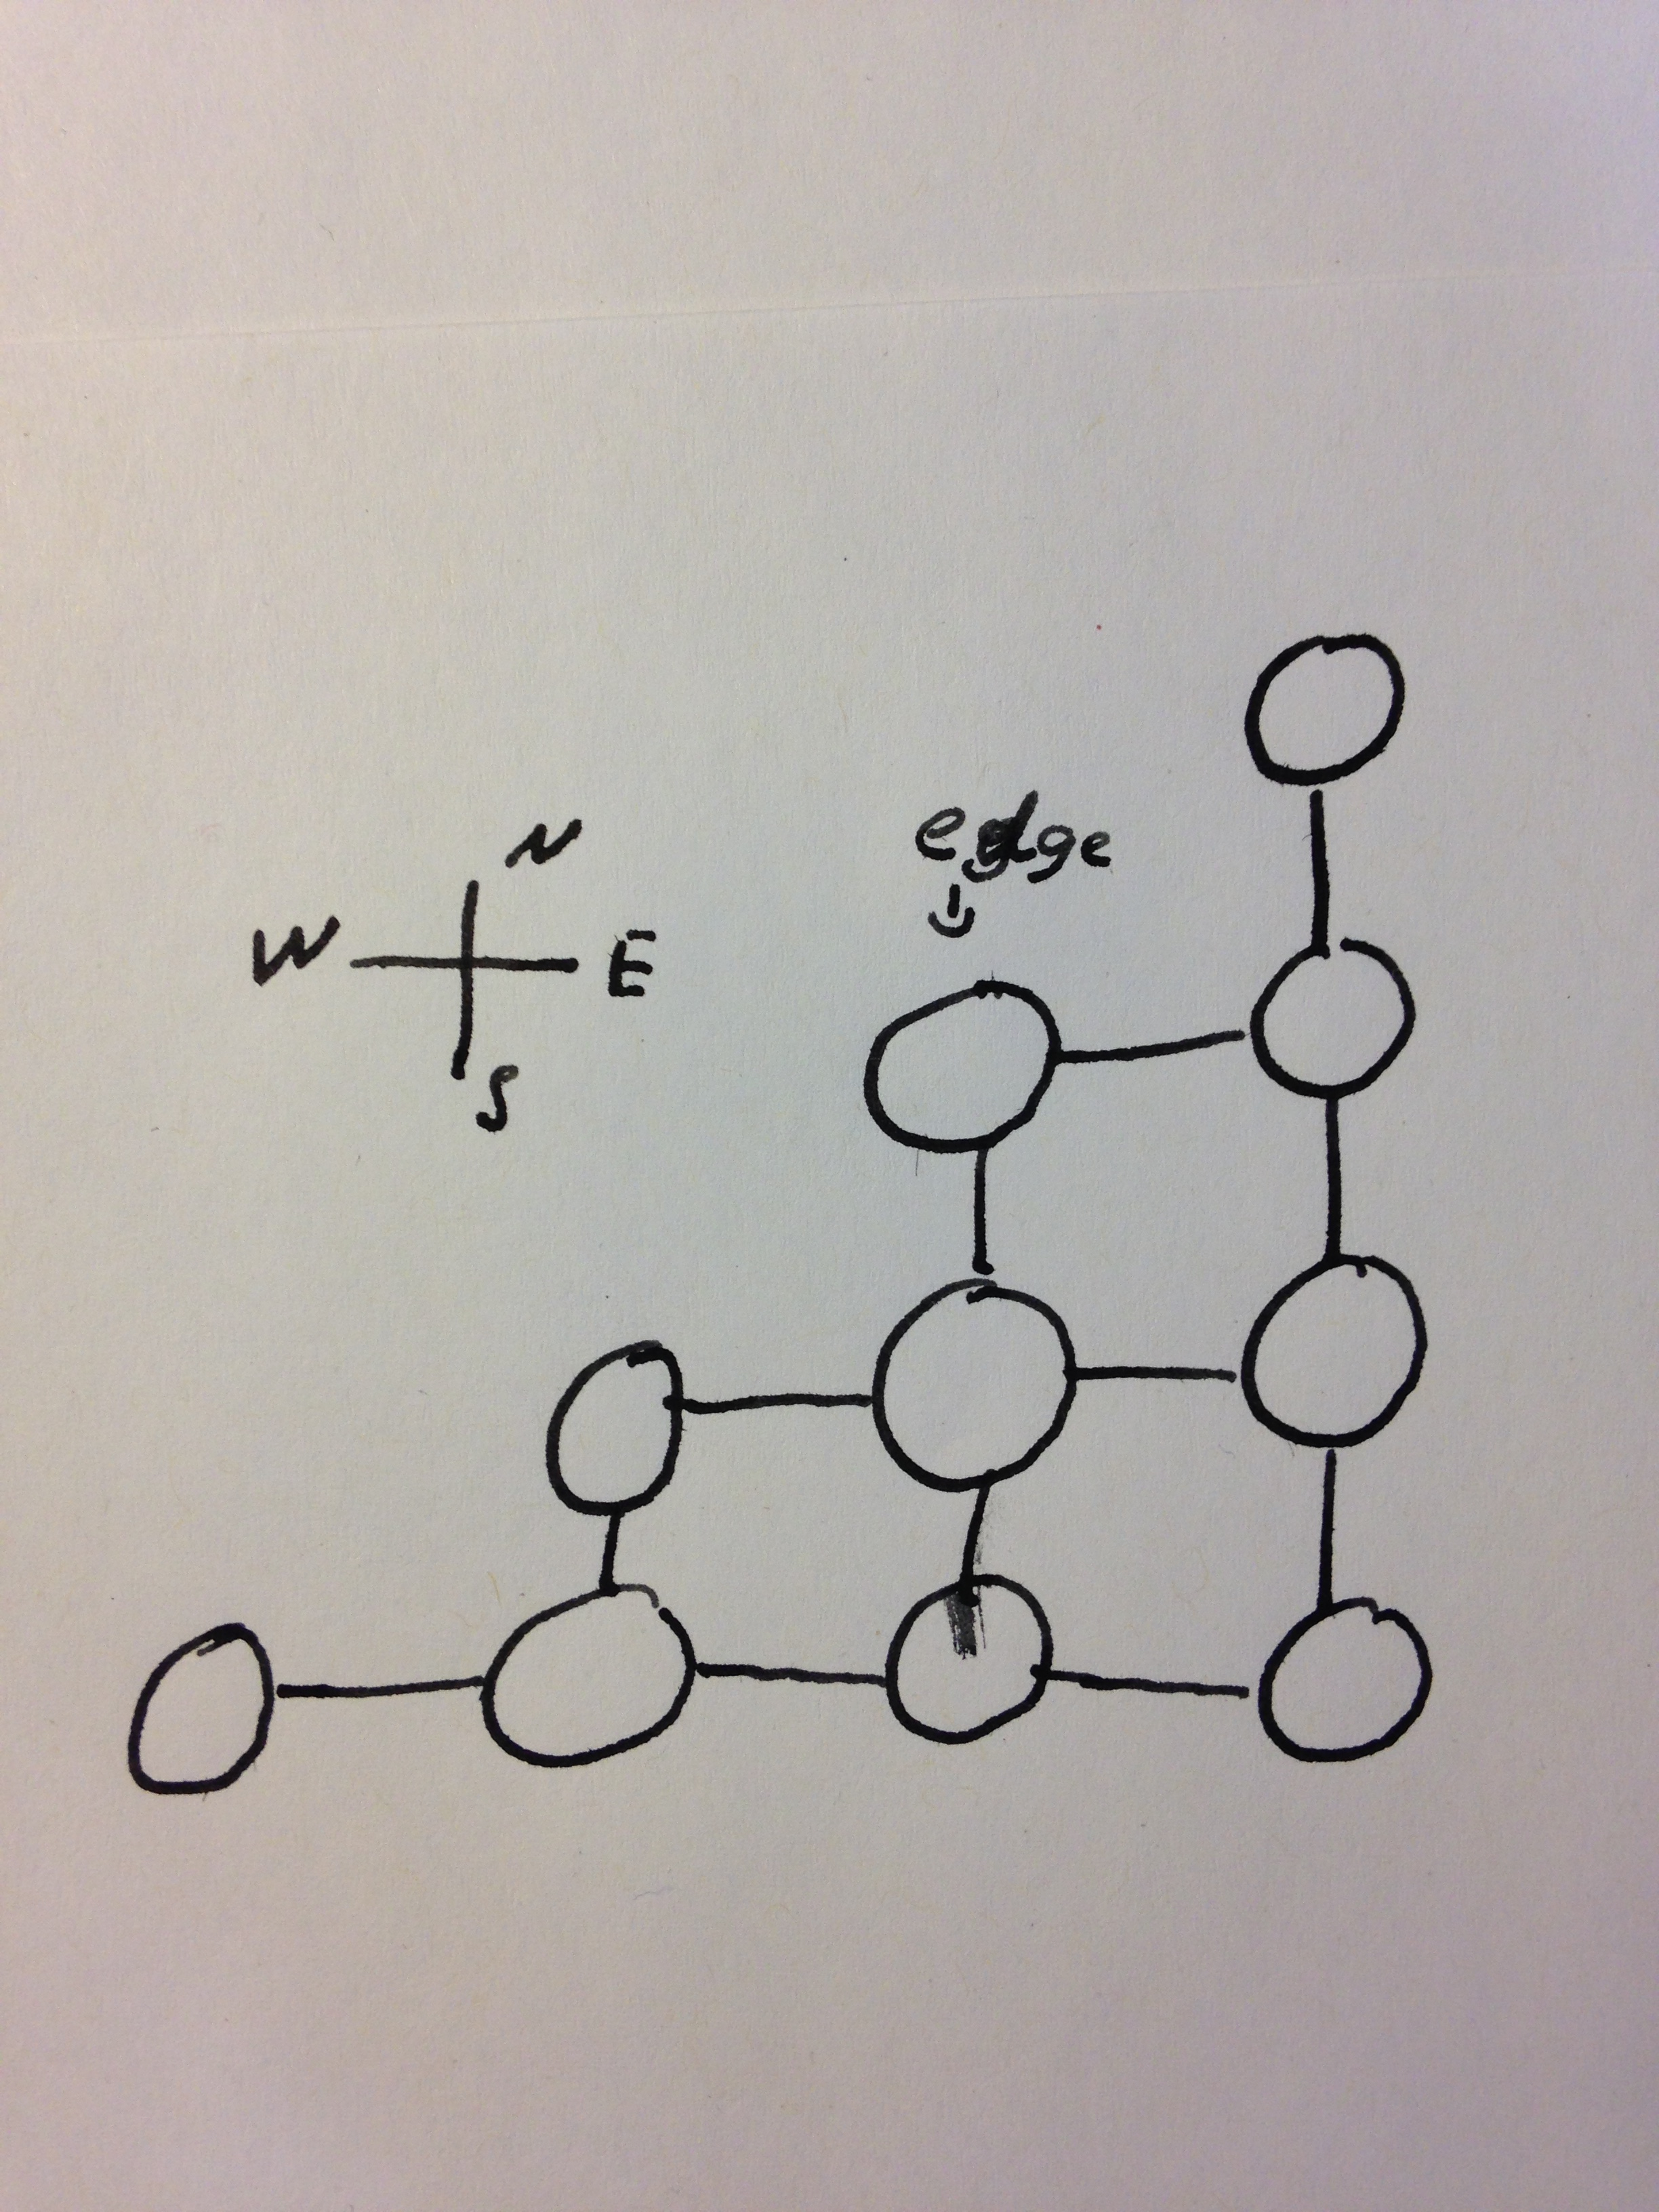

## Code

The main function for performing the TEMPO calculation is the function 

**tempo**`(eigl, eta, irho, ham, dt, ntot, dkm, p, c=1, mod=0, datf=None, saveMPS=None)`

The first input is the eigenvalues of the system-environment interaction. The next one is the Makri coefficient function (discretised two time bath correlations). Then the initial state of the system and the pure system Hamiltonian in the interaction operator basis. `dt` and `ntot` is the parameters for the trotter expansion. `dkm` is the finite memory cutoff. `p` is the the cut-off for when the bond indicies are neglected. It is set-up such that when, for a specific bond, the i'th value ($\alpha_i$) satisfies the inequality $\alpha_i<10^{-0.1 \cdot p}\alpha_{max}$. Where $\alpha_{max}$ is the value of the highest bond parameter.

The two last parameters defines the name of the datafile the results are written to and defines how often the MPS are saved throughout the calculation. This feature is very useful as calculations an then be repeated from these previously saved MPS files.

**edge**

This function creates a identity tensor with the two legs of dimesion equal to the system dimension ($D_s$) and one dummy leg which is contracted over so it only has a dummy west (left) index. This tensor is used at the end of each chain as the final time step (see picture).
**This has to be given twice as many indices but with a different dimension!**

## parameters

Next up is a bunch of parameters.
first a start time is defined as `t0`, $D_s$ is defined as `l` and the precision factor is defined as `precision`. The list named `svds` contains the three elements: `fration,accuracy,chi`

## Makri Coefficients

Next up the makri coefficient values are created in a table by the **qp** function. 

`qp.trot=0
qp.ctab=qp.mcoeffs(mod, eta, dkm, dt, ntot)`

The $mod$ value is just related to how the makricoefficients are computed. The standard method is $mod=0$ which is just computing the makri coefficient up until the cut-off. The modified version $mod=1$ is one where the everything outside of the cut-off is integrated over and included the the last value.  

## Liouville space mapping

The liouville space mapping is not unique and the properties of the mapping depends upon which mapping is chosen. Normally in mathematical vectorisation one stacks the columns to create a vector. In the code this is different as here rows are stacked to create the vector. **This operation also has to be adapted to the new liouville space structure**

`rho=np.array(irho).reshape(l**2)
datlis=[[0,rho]]`

The last line creates a datalist for which the purpose is currently **unclear?** Most likely it this datalist will have the density matrix at the next time added in the "empty" place. A new element is then most likely added for each timestep. If true this element will contain the reduced density matrices for all times. 

## Initialising MPS

The first object used is the `mps_block` object. This is a class which defines a block of MPS'. That means it is a string with 3-leg tensors at each site. The total length of the string is `N_sites`. The local physical dimension of the site is set by the `SNdim`. The bond dimesions on either side of the site is set by `Wdim`, `Edim` accordingly. 

In [ ]:
##########################################################################
#   Class mps_block   
#
#   Synopsis:
#   Defines a block of MPS sites (i.e. a 3-leg tensor at each site)
#   with the total length of MPS block = N_sites.
#
#   Looping over all sites of the MPS block do the following:
#   Set SNdim = local dimension of Hilbert/Liouville space at each site
#   Set Wdim,Edim = the bond sizes to the west & to the east of a site 
#   
#   Since MPS is constructed by series of SVDs applied to the original state, 
#   the maximum (untruncated) bond size to the west of MPS site 
#   (appearing after SVD) can be: chi0 = min{d^{site}, d^(N-site)}. 
#   To avoid the exp growth of the bond size as we go further away from the ends
#   of MPS, we will truncate the bond size chi0 to the target bond size = bond_dim
#   (i.e. if chi0 > bond_dim, we truncate the full bond chi0 to bond_dim)
#   
#   Extra function - copy_mps_block:
#   Creates a copy of the MPS = mps_copy with length N_sites
#   if copy_conjugate = True, creates mps_copy = HC of the original MPS
#   else, creates mps_copy = original MPS 
#
#   CAVEAT: here, we assume that SNdim = uniform over all MPS sites
#   In the cases where this is not true, we'll need to make a slight 
#   modification to this part of the code. 
########################################################################### 
class mps_block():

 def __init__(self, local_dim, bond_dim, N_sites):

    #set the length of mps_block
    self.N_sites = N_sites

    #initialize list of mps_sites
    self.data = []

    #keep track of sites multiplied by MPO
    self.is_multiplied=[]

    #Note that Python numbers its lists from 0 to N-1!!!
    for site in range(N_sites):

       #Distance from the chain end below which we should consider rescaling. 
       #We should not even try to calculate bond_dim**site if site is too far 
       #from the end as this might lead to an integer overflow.
       cutoff_distance = np.ceil(np.log(bond_dim)/np.log(local_dim))

       #Determine west_dim for each site
       west_distance = np.minimum(site, N_sites-site)
       if west_distance < cutoff_distance:
            west_dim=np.minimum(bond_dim, local_dim**west_distance)
       else:
            west_dim=bond_dim

       #Determine east_dim for each site
       east_distance = np.minimum(site+1, N_sites-(site+1))
       if east_distance < cutoff_distance:
            east_dim=np.minimum(bond_dim, local_dim**east_distance)
       else:
            east_dim=bond_dim
     
       #Create a new mps_site
       self.data.append(mps_site(local_dim, west_dim, east_dim))